In [1]:
import cell2cell as c2c
import numpy as np
import pandas as pd
import tissue_enrichment_analysis as tea

from collections import defaultdict
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

**Ligand-receptor pairs**

In [2]:
ga_lrs = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv')

In [3]:
ga_lrs.shape

(37, 11)

In [4]:
bkg_lrs = pd.read_excel('../Data/PPI-Networks/Celegans-Curated-LR-pairs.xlsx')

**RNA-seq data**

In [5]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file='../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx',
                                 gene_column='symbol',
                                 drop_nangenes=True,
                                 log_transformation=False,
                                 format='auto')

Opening RNAseq datasets from ../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


In [6]:
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [7]:
rnaseq_data = rnaseq_data.drop(excluded_cells, axis=1)

**Metadata for cell types**

In [8]:
meta = c2c.io.load_metadata(metadata_file='../Data/RNA-Seq/Celegans_cell_metadata.tsv',
                            cell_labels=list(rnaseq_data.columns),
                            index_col='#SampleID',
                            format='auto')

../Data/RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


# Enrichment analysis

**Dictionary for converting gene IDs from WormBase into symbol**

In [9]:
mapper = dict(zip(bkg_lrs['Ligand_WB'].values.tolist(), bkg_lrs['Ligand_symbol'].values.tolist()))
mapper.update((zip(bkg_lrs['Receptor_WB'].values.tolist(), bkg_lrs['Receptor_symbol'].values.tolist())))

In [10]:
len(mapper)

190

**Input genes**

In [11]:
id_type = 'WB' # symbol or WB

In [12]:
ga_genes = set(ga_lrs[['Ligand_' + id_type, 'Receptor_' + id_type]].values.flatten().tolist())

In [13]:
bkg_genes = set(bkg_lrs[['Ligand_' + id_type, 'Receptor_' + id_type]].values.flatten().tolist())

**Fetch Phenotypes from WormBase using their tool (tea)**

**Disclaimer:** This information could change depending on the updates from WormBase, altering the analyses that follow. This might cause that results reported in the paper are not consistent with this notebook

In [14]:
phenotype = tea.fetch_dictionary('phenotype')

In [15]:
phenotype.set_index('wbid', inplace=True)

Use only genes in our complete list of LR pairs (use them as background genes)

In [16]:
phenotype = phenotype.reindex(bkg_genes)

**Fisher Exact Test**

In [17]:
n = len(ga_genes)
N = len(bkg_genes)

records = []
for c in phenotype.columns:
    phe_df = phenotype[c]
    sam_phe_df = phe_df.reindex(ga_genes)
    
    test_n = sam_phe_df.sum()
    test_N = phe_df.sum()
    test = c2c.stats.enrichment.fisher_representation(n, test_n, N, test_N)
    if N == 0:
        exp = np.nan
    else:
        exp = n/N
    if test_N == 0:
        obs = np.nan
    else:   
        obs = test_n/test_N
    test['fold'] = (exp, obs)
    records.append((c, test['odds'][1], test['pval'][1], *test['fold']))

In [18]:
results = pd.DataFrame.from_records(records, 
                                    columns = ['Term', 
                                               'Enrichment Fold Change', 
                                               'P value', 
                                               'Expected', 
                                               'Observed'])

**Multiple test correction (adjust P-values with FDR Benjamini & Hochberg, and select FDR < 1%)**

In [19]:
fdr = 0.01
results['Q value'] = c2c.stats.compute_fdrcorrection_asymmetric_matrix(results[['P value']], alpha=fdr)
results['logQ'] = -results['Q value'].apply(np.log10)
# remove np.infinites with np.nan
results.logQ.replace([np.inf], np.nan, inplace=True)
# remove np.nan with 70
results.logQ.replace(np.nan, 70, inplace=True)

In [20]:
significant_results = results.loc[results['Q value'] < fdr]
significant_results.sort_values('Q value', ascending=True)

,Term,Enrichment Fold Change,P value,Expected,Observed,Q value,logQ
208,organ system phenotype WBPhenotype:0002554,4.130435,0.000012,0.310526,0.5,0.002911,2.536017


/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


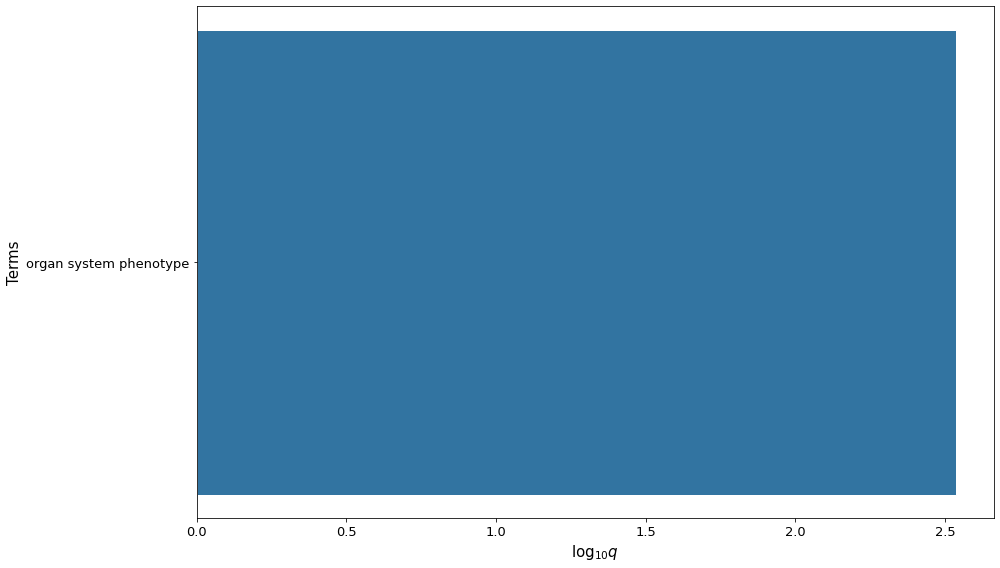

In [21]:
tea.plot_enrichment_results(significant_results, title='Phenotype', analysis='Phenotype', y='logQ', n_bars=10)

**GA selected genes involved**

In [22]:
associated_genes = defaultdict(set)
ga_associated_genes = defaultdict(set)
for idx, row in significant_results.iterrows():
    term = row['Term']
    associated_genes[term] = set([mapper[g] for g in phenotype.loc[phenotype[term] > 0, term].index])
    ga_associated_genes[term] = associated_genes[term] & set([mapper[g] for g in ga_genes])

In [23]:
fraction = len(ga_associated_genes[term]) / len(associated_genes[term])
print('{} is the fraction of genes associated to the enriched phenotype in the complete list of LR pairs and that were \
       selected by the genetic algorithm'.format(np.round(fraction, 2)))

0.5 is the fraction of genes associated to the enriched phenotype in the complete list of LR pairs and that were        selected by the genetic algorithm


# Visualization of presence/absence given gene expression and selected genes

In [24]:
expression = rnaseq_data.gt(10)

In [25]:
# Colors from figure S14 in C elegans paper (cell type expression data)
colors = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
          'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
          'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
          'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
          'Intestine': (1.0, 1.0, 0.2), # Yellow
          'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
          'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
          'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

In [26]:
cell_colors = meta[['Groups']]
cell_colors['Groups'] = cell_colors['Groups'].map(colors)

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


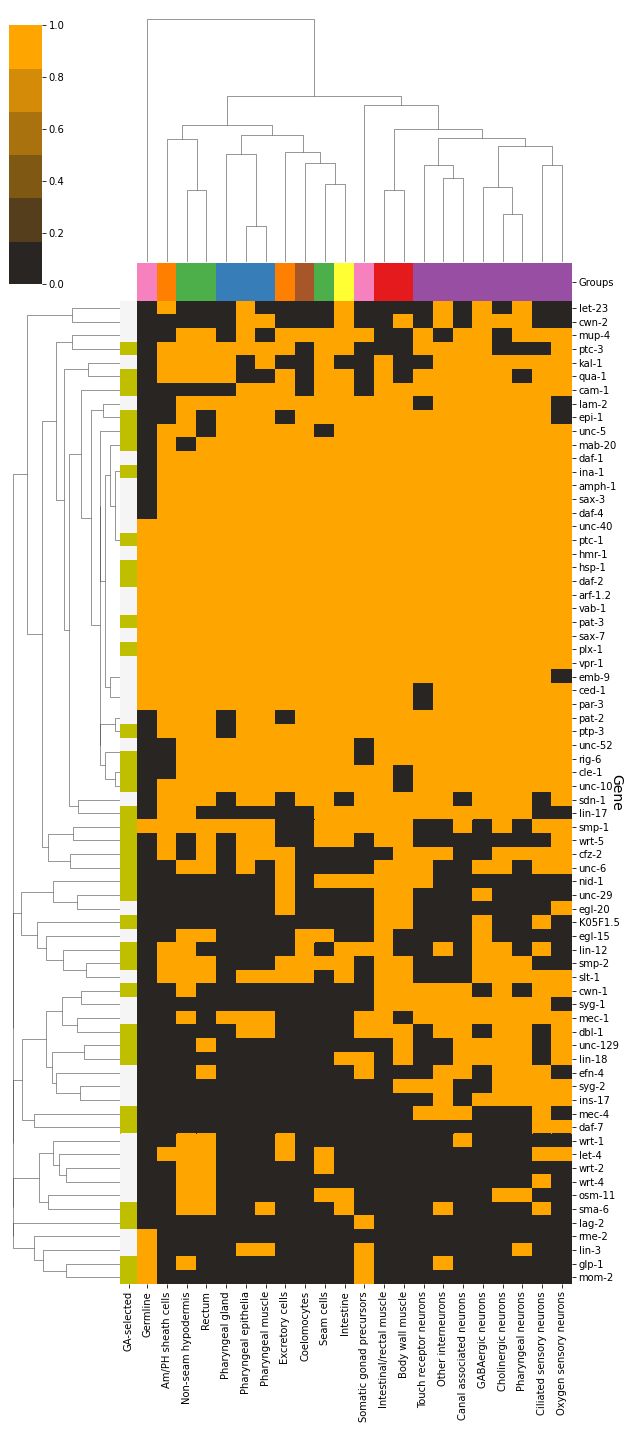

In [27]:
gene_list = associated_genes[term]

colors = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in ga_associated_genes[term]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[gene_list],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    row_colors=color_df[['GA-selected']],
                    col_colors=cell_colors,
                    figsize=(9, 20),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))
cm.ax_heatmap.set_ylabel('Gene', fontsize=14, rotation=-90)

plt.savefig('../Figures/Phenotype-Association.svg',
                dpi=300,
                bbox_inches='tight')

In [28]:
ga_lrs.loc[(ga_lrs.Ligand_symbol.isin(gene_list)) & (ga_lrs.Receptor_symbol.isin(gene_list))]

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,score,index,LR Function,L Function,R Function,Ligand_desc,Receptor_desc
0,WBGene00000903,WBGene00004860,daf-7,sma-6,1.0,1,TGF-B signaling,GDF11,BMPRIB,Is an ortholog of human GDF11 (growth differen...,Is an ortholog of human BMPR1A (bone morphogen...
8,WBGene00003738,WBGene00004215,nid-1,ptp-3,1.0,46,Cell adhesion,Nidogen,LAR-RPTP,Is an ortholog of human NID1 (nidogen 1) and N...,Is an ortholog of human PTPRD (protein tyrosin...
10,WBGene00001328,WBGene00003930,epi-1,pat-3,1.0,54,Cell adhesion,Laminin,Integrin,Is an ortholog of human LAMA5 (laminin subunit...,Is an ortholog of human ITGB1 (integrin subuni...
11,WBGene00000857,WBGene00003006,cwn-1,lin-17,1.0,57,Wnt signaling,Wnt,Frizzled,Is an ortholog of human WNT4 (Wnt family membe...,Is an ortholog of human FZD4 (frizzled class r...
13,WBGene00006750,WBGene00006765,unc-10,unc-29,1.0,62,Neuronal communication,Organization of presynaptic sites,Cholinergic Receptor,Is an ortholog of human RIMS1 (regulating syna...,Is an ortholog of several human genes includin...
16,WBGene00003395,WBGene00003007,mom-2,lin-18,1.0,101,Wnt signaling,Wnt,Ryk/Derailed,Exhibits receptor tyrosine kinase binding acti...,Is an ortholog of human RYK (receptor like tyr...
22,WBGene00004264,WBGene00004210,qua-1,ptc-3,1.0,148,Hedgehog signaling,IHH,PTCH2,Is an ortholog of human DHH (desert hedgehog s...,Is an ortholog of human PTCH1 (patched 1) and ...
23,WBGene00004890,WBGene00004047,smp-2,plx-1,1.0,155,Cell migration,Semaphorin,Plexin (semaphorin receptor),Is an ortholog of several human genes includin...,Is an ortholog of human PLXNA2 (plexin A2); PL...
24,WBGene00004889,WBGene00004047,smp-1,plx-1,1.0,156,Cell migration,Semaphorin,Plexin (semaphorin receptor),Is an ortholog of human SEMA6A (semaphorin 6A)...,Is an ortholog of human PLXNA2 (plexin A2); PL...
26,WBGene00006951,WBGene00004208,wrt-5,ptc-1,1.0,168,Hedgehog signaling,DHH,PTCH1,Is predicted to have signaling receptor bindin...,Is an ortholog of human PTCH1 (patched 1) and ...
